## Requirements

In [1]:
import pandas as pd
import numpy as np
import statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller

## Using pairs trading strategy on Oil Prices

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

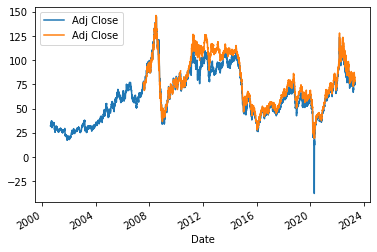

In [2]:
## Pair - WTI Crude Oil and BRENT Crude Oil
series1 = yf.download('CL=F')
series2 = yf.download('BZ=F')
pd.concat([series1['Adj Close'],series2['Adj Close']], axis=1).plot()

#### I have chosen these pairs because they belong to the same sector, i.e oil sector and are largely correlated, hence become good candidates for cointegration.

### Training

In [3]:
## Downloading data

start_date='2016-01-01'
end_date='2017-01-01'

series1 = yf.download('CL=F',start=start_date, end=end_date)
series2 = yf.download('BZ=F',start=start_date, end=end_date)
pd.concat([series1['Adj Close'],series2['Adj Close']], axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Adj Close,Adj Close
Date,,
2016-01-04,36.759998,37.220001
2016-01-05,35.970001,36.419998
2016-01-06,33.970001,34.230000
2016-01-07,33.270000,33.750000
2016-01-08,33.160000,33.549999
...,...,...
2016-12-23,53.020000,55.160000
2016-12-27,53.900002,56.090000
2016-12-28,54.060001,56.220001


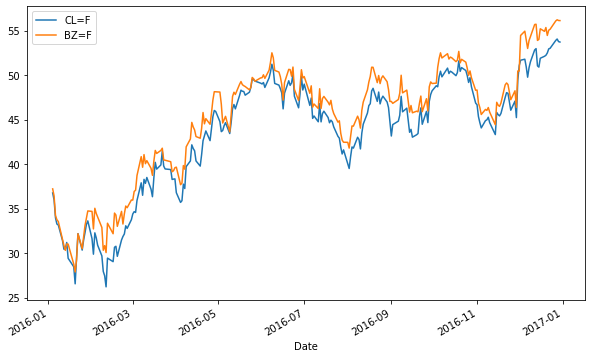

In [4]:
## Plotting closing prices

X = series1['Adj Close']
Y = series2['Adj Close']
pd.concat([X,Y], axis=1).plot(figsize=(10,6))
plt.legend(['CL=F','BZ=F'])

In [5]:
## Compute the p value of the cointegration test (Engel-Granger Test)

score, pvalue, _ = coint(X,Y)    ## Tests for the null hypothesis that X and Y are not cointegrated
if pvalue<0.05:
    print("Likely cointegration with p value = {}".format(pvalue)) ## If pvalue < 0.05 we can reject the null hypo
else:
    print("Not cointegrated")

Likely cointegration with p value = 0.012362264479600059


In [6]:
pvalue

0.012362264479600059

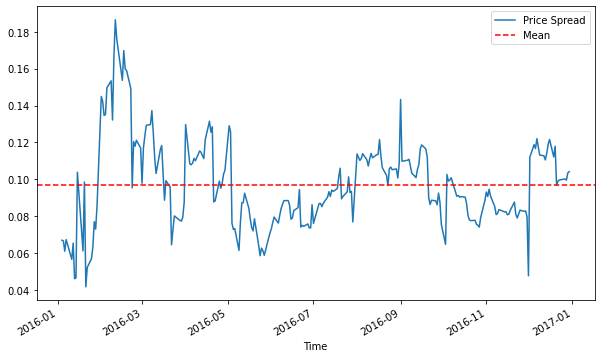

In [7]:
## Plotting the spread and its mean

X = sm.add_constant(X)
results = sm.OLS(Y,X).fit()
X = X['Adj Close']
b = results.params['Adj Close']

spread = np.log(Y) - b * np.log(X)
spread.plot(figsize=(10,6))
plt.axhline(spread.mean(),color='red',linestyle='--')
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [8]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 1.316e+04
Date:                Tue, 02 May 2023   Prob (F-statistic):          6.85e-217
Time:                        20:04:08   Log-Likelihood:                -329.69
No. Observations:                 250   AIC:                             663.4
Df Residuals:                     248   BIC:                             670.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3819      0.377      6.313      0.000       1.639       3.125
Adj Close      0.9849      0.009    114.708      0.000       0.968       1.002
==============================================================================
Omnibus:                        4.409   Durbin-Watson:                   0.372
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                2.904
Skew:                          -0.063   Prob(JB):                        0.234
Kurtosis:                       2.487   Cond. No.                         289.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
X.mean()

43.435800033569336

In [10]:
Y.mean()

45.16007995605469

In [11]:
print("Beta value = {}".format(round(b,4)))

Beta value = 0.9849


In [12]:
print("Mean value of the spread = ", round(spread.mean(),3))

Mean value of the spread =  0.097


#### Checking for the stationary of the spread:

In [13]:
# Run the Augmented Dickey-Fuller test on the spread values
adf_result = adfuller(spread, autolag='AIC')

# Extract the test statistic, p-value, and critical values
adf_statistic = adf_result[0]
adf_pvalue = adf_result[1]
adf_critical_values = adf_result[4]

# Print the results
print(f'ADF Statistic: {adf_statistic:.3f}')
print(f'p-value: {adf_pvalue:.3f}')
print('Critical Values:')
for key, value in adf_critical_values.items():
    print(f'   {key}: {value:.3f}')
    
# Interpret the results
if adf_pvalue < 0.05:
    print('Reject the null hypothesis. The spread is stationary.')
else:
    print('Fail to reject the null hypothesis. The spread is non-stationary.')

ADF Statistic: -3.583
p-value: 0.006
Critical Values:
   1%: -3.457
   5%: -2.873
   10%: -2.573
Reject the null hypothesis. The spread is stationary.


#### The spread obtained is stationary.

### Computing Z scores

In [14]:
def zscore(series):
    return (series - series.mean())/ np.std(series)

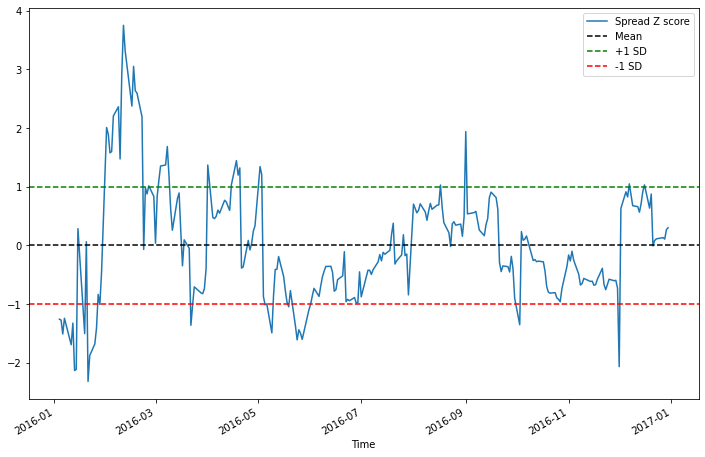

In [15]:
zscore(spread).plot(figsize=(12,8))
plt.axhline(zscore(spread).mean(),color='black',linestyle='--')
plt.axhline(1.0,color='green',linestyle='--')
plt.axhline(-1.0,color='red',linestyle='--')
plt.xlabel('Time')
plt.legend(['Spread Z score', 'Mean','+1 SD', '-1 SD'])

### Building pairs trading strategy

In [16]:
## Calculating weights/hedge ratio for pairs in portfolio, w1 for WTI and w2 for Brent
w1 = 1/(1+b)
w2 = 1- w1

#### Assumption: The hedge ratio is constant.

In [17]:
## Computing portfolio value for each day
pf_value = w1*Y - w2*X

In [18]:
# Create a DataFrame with the signal and position size in the pair

trades = pd.concat([zscore(spread), pf_value], axis=1)
trades.columns = ["Signal", "Portfolio Value"]
trades

,Signal,Portfolio Value
Date,,
2016-01-04,-1.259462,0.512162
2016-01-05,-1.273383,0.501094
2016-01-06,-1.511141,0.390114
2016-01-07,-1.243625,0.495614
2016-01-08,-1.356002,0.449432
...,...,...
2016-12-23,0.109791,1.482599
2016-12-27,0.131053,1.514502
2016-12-28,0.105739,1.500609


In [19]:
trades['Value change'] = trades['Portfolio Value'].pct_change()

In [20]:
pd.set_option('display.max_rows', 500)

In [21]:
pos = 0
prev_position = 0
flag = False
trades['Position'] = 0
for date, row in trades.iterrows():
    signal = row['Signal']
    if flag == False:
        if (signal <= -1 and signal >= -2): #Stop Loss
            trades.loc[date, 'Position'] = prev_position + 1
            flag = True
            prev_position = trades.loc[date, 'Position']
            pos = 1
        elif (signal >= 1 and signal<= 2):
            trades.loc[date, 'Position'] = prev_position -1
            flag = True
            prev_position = trades.loc[date, 'Position']
            pos = -1
    elif flag == True:
        if pos == 1:
            if (signal >= 0):
                trades.loc[date, 'Position'] = prev_position -1
                flag = False
                prev_position = trades.loc[date, 'Position']
                pos = 0
            elif (signal <= -2): #Stop Loss
                trades.loc[date, 'Position'] = prev_position -1
                flag = False
                prev_position = trades.loc[date, 'Position']
                pos = 0
            else:
                trades.loc[date, 'Position'] = prev_position
        elif pos == -1:
            if (signal <= 0):
                trades.loc[date, 'Position'] = prev_position + 1
                flag = False
                prev_position = trades.loc[date, 'Position']
                pos = 0
            elif (signal >= 2): #Stop Loss
                trades.loc[date, 'Position'] = prev_position + 1
                flag = False
                prev_position = trades.loc[date, 'Position']
                pos = 0
            else:
                trades.loc[date, 'Position'] = prev_position

In [22]:
prev_pf_value = None
trades['UnRealized PnL'] = 0
for date, row in trades.iterrows():
    if prev_pf_value is None:
        trades.loc[date,'UnRealized PnL'] = row['Portfolio Value']
        prev_pf_value = row['Portfolio Value']
    else:
        trades.loc[date, 'UnRealized PnL'] = row['Portfolio Value'] - prev_pf_value
trades

,Signal,Portfolio Value,Value change,Position,UnRealized PnL
Date,,,,,
2016-01-04,-1.259462,0.512162,NaN,1,0.512162
2016-01-05,-1.273383,0.501094,-0.021609,1,-0.011067
2016-01-06,-1.511141,0.390114,-0.221475,1,-0.122047
2016-01-07,-1.243625,0.495614,0.270434,1,-0.016547
2016-01-08,-1.356002,0.449432,-0.093182,1,-0.062730
2016-01-11,-1.693983,0.310130,-0.309952,1,-0.202032
2016-01-12,-1.326044,0.443799,0.431011,1,-0.068363
2016-01-13,-2.133751,0.146853,-0.669099,0,-0.365308
2016-01-14,-2.113516,0.152346,0.037399,0,-0.359816


In [23]:
prev_position = None
position_changes = []
trades['Change Value'] = 0
trades['Returns'] = 0
trades['Cumulative Returns'] = 0
trades['Realized PnL'] = 0
for date, row in trades.iterrows():
    if prev_position is None or row['Position'] != prev_position:
        #position_changes.append(row)
        trades.loc[date,'Change Value'] = 6 #Some arbitrary number
    prev_position = row['Position']

trades.dropna(inplace=True)
trades

,Signal,Portfolio Value,Value change,Position,UnRealized PnL,Change Value,Returns,Cumulative Returns,Realized PnL
Date,,,,,,,,,
2016-01-05,-1.273383,0.501094,-0.021609,1,-0.011067,0,0,0,0
2016-01-06,-1.511141,0.390114,-0.221475,1,-0.122047,0,0,0,0
2016-01-07,-1.243625,0.495614,0.270434,1,-0.016547,0,0,0,0
2016-01-08,-1.356002,0.449432,-0.093182,1,-0.062730,0,0,0,0
2016-01-11,-1.693983,0.310130,-0.309952,1,-0.202032,0,0,0,0
2016-01-12,-1.326044,0.443799,0.431011,1,-0.068363,0,0,0,0
2016-01-13,-2.133751,0.146853,-0.669099,0,-0.365308,6,0,0,0
2016-01-14,-2.113516,0.152346,0.037399,0,-0.359816,0,0,0,0
2016-01-15,0.283618,1.025480,5.731279,0,0.513319,0,0,0,0


In [24]:
date_first_occurence = trades['Change Value'].idxmax()
prev_pf_value = trades.loc[date_first_occurence,'Portfolio Value']
prev_pos = trades.loc[date_first_occurence,'Position']
for date, row in trades.iterrows():
    if row['Change Value'] == 6:
        if prev_pos == 1 and row['Position'] == 0:
            returns = (row['Portfolio Value'] - prev_pf_value)/ (prev_pf_value) 
            trades.loc[date, 'Returns'] = returns
            trades.loc[date, 'Realized PnL'] = row['Portfolio Value'] - prev_pf_value
            prev_pf_value = row['Portfolio Value']
            prev_pos = row['Position']
            #trades.loc[date,'Previous Pf Value'] = prev_pf_value
            #trades.loc[date,'Previous Pos'] = prev_pos
        elif prev_pos == 0 and row['Position'] == 1:
            prev_pos = row['Position']
            prev_pf_value = row['Portfolio Value']
        elif prev_pos == 0 and row['Position'] == -1:
            prev_pos = row['Position']
            prev_pf_value = row['Portfolio Value']
        elif prev_pos == -1 and row['Position'] == 0:
            returns = (prev_pf_value - row['Portfolio Value'])/ (prev_pf_value) 
            trades.loc[date, 'Returns'] = returns
            trades.loc[date, 'Realized PnL'] = prev_pf_value - row['Portfolio Value']
            prev_pf_value = row['Portfolio Value']
            prev_pos = row['Position']
trades

,Signal,Portfolio Value,Value change,Position,UnRealized PnL,Change Value,Returns,Cumulative Returns,Realized PnL
Date,,,,,,,,,
2016-01-05,-1.273383,0.501094,-0.021609,1,-0.011067,0,0.000000,0,0.000000
2016-01-06,-1.511141,0.390114,-0.221475,1,-0.122047,0,0.000000,0,0.000000
2016-01-07,-1.243625,0.495614,0.270434,1,-0.016547,0,0.000000,0,0.000000
2016-01-08,-1.356002,0.449432,-0.093182,1,-0.062730,0,0.000000,0,0.000000
2016-01-11,-1.693983,0.310130,-0.309952,1,-0.202032,0,0.000000,0,0.000000
2016-01-12,-1.326044,0.443799,0.431011,1,-0.068363,0,0.000000,0,0.000000
2016-01-13,-2.133751,0.146853,-0.669099,0,-0.365308,6,0.000000,0,0.000000
2016-01-14,-2.113516,0.152346,0.037399,0,-0.359816,0,0.000000,0,0.000000
2016-01-15,0.283618,1.025480,5.731279,0,0.513319,0,0.000000,0,0.000000


In [25]:
trades['Cumulative Returns'] = (1+trades['Returns']).cumprod()
trades['Cumulative PnL'] = trades['Realized PnL'].cumsum()
trades.dropna(inplace = True)
trades

,Signal,Portfolio Value,Value change,Position,UnRealized PnL,Change Value,Returns,Cumulative Returns,Realized PnL,Cumulative PnL
Date,,,,,,,,,,
2016-01-05,-1.273383,0.501094,-0.021609,1,-0.011067,0,0.000000,1.000000,0.000000,0.000000
2016-01-06,-1.511141,0.390114,-0.221475,1,-0.122047,0,0.000000,1.000000,0.000000,0.000000
2016-01-07,-1.243625,0.495614,0.270434,1,-0.016547,0,0.000000,1.000000,0.000000,0.000000
2016-01-08,-1.356002,0.449432,-0.093182,1,-0.062730,0,0.000000,1.000000,0.000000,0.000000
2016-01-11,-1.693983,0.310130,-0.309952,1,-0.202032,0,0.000000,1.000000,0.000000,0.000000
2016-01-12,-1.326044,0.443799,0.431011,1,-0.068363,0,0.000000,1.000000,0.000000,0.000000
2016-01-13,-2.133751,0.146853,-0.669099,0,-0.365308,6,0.000000,1.000000,0.000000,0.000000
2016-01-14,-2.113516,0.152346,0.037399,0,-0.359816,0,0.000000,1.000000,0.000000,0.000000
2016-01-15,0.283618,1.025480,5.731279,0,0.513319,0,0.000000,1.000000,0.000000,0.000000


<AxesSubplot:xlabel='Date'>

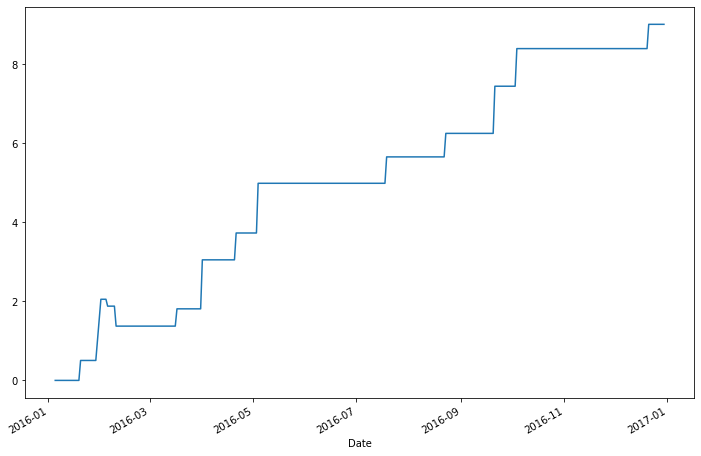

In [26]:
trades['Cumulative PnL'].plot(figsize=(12,8))

In [27]:
# Sharpe Ratio
sharpe_ratio = np.sqrt(252) * trades['Returns'].mean() / trades['Returns'].std()

# Maximum Drawdown
cumulative_returns = np.array(trades['Cumulative Returns'])
peak = np.maximum.accumulate(cumulative_returns)
drawdown = (cumulative_returns - peak) / peak
max_drawdown = np.min(drawdown)

print(f"Sharpe Ratio of the Trading Stategy: {round(sharpe_ratio,2)}")
print(f"Maximum Drawdown of the Trading Stategy: {round(max_drawdown,2)}")

Sharpe Ratio of the Trading Stategy: 2.06
Maximum Drawdown of the Trading Stategy: -0.43


### Testing on out-of-sample data

In [28]:
test_start_date='2017-01-05'
test_end_date='2017-04-05'

test_series1 = yf.download('CL=F',start=test_start_date, end=test_end_date)
test_series2 = yf.download('BZ=F',start=test_start_date, end=test_end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

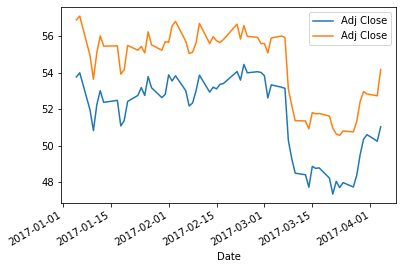

In [29]:
X_test = test_series1['Adj Close']
Y_test = test_series2['Adj Close']
pd.concat([X_test,Y_test], axis=1).plot()

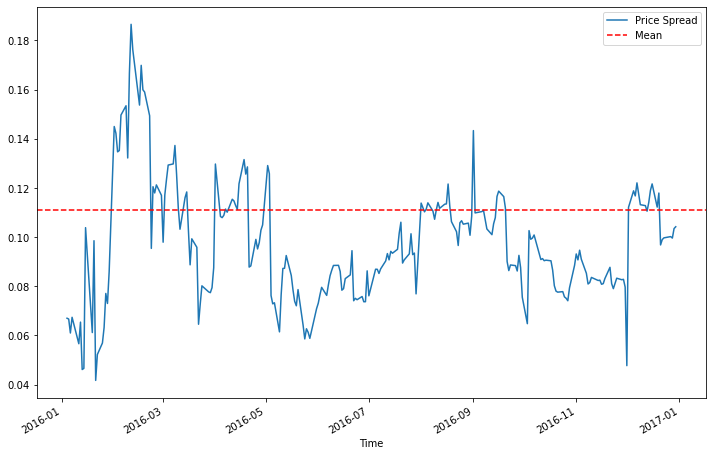

In [30]:
spread_test = np.log(Y_test) - b* np.log(X_test)
spread.plot(figsize=(12,8))
plt.axhline(spread_test.mean(),color='red',linestyle='--')
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [31]:
spread.mean()

0.09706664365726221

In [32]:
spread_test.mean()

0.11090077820081123

In [33]:
score, pvalue, _ = coint(X_test,Y_test)    ## Tests for the null hypothesis that X and Y are not cointegrated
if pvalue<0.05:
    print("Likely cointegration with p value = {}".format(pvalue)) ## If pvalue < 0.05 we can reject the null hypo
else:
    print("Not cointegrated")

Likely cointegration with p value = 0.00097982017511159


In [34]:
pf_value_test = w1*Y_test - w2*X_test

In [35]:
trades_test = pd.concat([zscore(spread_test), pf_value_test], axis=1)
trades_test.columns = ["Signal", "Portfolio Value"]
trades_test

,Signal,Portfolio Value
Date,,
2017-01-05,0.745346,1.987020
2017-01-06,0.680926,1.978696
2017-01-09,0.579599,1.897717
2017-01-10,0.319678,1.808411
2017-01-11,0.260823,1.834433
2017-01-12,0.528204,1.915803
2017-01-13,0.765329,1.951227
2017-01-17,0.554021,1.906723
2017-01-18,0.342044,1.820469


In [36]:
trades_test['Value change'] = trades_test['Portfolio Value'].pct_change()

In [37]:
trades_test['Position'] = 0.0
trades_test.loc[trades_test.Signal <= -1, "Position"] = 1
trades_test.loc[trades_test.Signal >= 1, "Position"] = -1

In [38]:
pos = 0
prev_position = 0
flag = False
trades_test['Position'] = 0
for date, row in trades_test.iterrows():
    signal = row['Signal']
    if flag == False:
        if (signal <= -1 and signal >= -2): #Stop Loss
            trades_test.loc[date, 'Position'] = prev_position + 1
            flag = True
            prev_position = trades_test.loc[date, 'Position']
            pos = 1
        elif (signal >= 1 and signal<= 2):
            trades_test.loc[date, 'Position'] = prev_position -1
            flag = True
            prev_position = trades_test.loc[date, 'Position']
            pos = -1
    elif flag == True:
        if pos == 1:
            if (signal >= 0):
                trades_test.loc[date, 'Position'] = prev_position -1
                flag = False
                prev_position = trades_test.loc[date, 'Position']
                pos = 0
            elif (signal <= -2): #Stop Loss
                trades_test.loc[date, 'Position'] = prev_position -1
                flag = False
                prev_position = trades_test.loc[date, 'Position']
                pos = 0
            else:
                trades_test.loc[date, 'Position'] = prev_position
        elif pos == -1:
            if (signal <= 0):
                trades_test.loc[date, 'Position'] = prev_position + 1
                flag = False
                prev_position = trades_test.loc[date, 'Position']
                pos = 0
            elif (signal >= 2): #Stop Loss
                trades_test.loc[date, 'Position'] = prev_position + 1
                flag = False
                prev_position = trades_test.loc[date, 'Position']
                pos = 0
            else:
                trades_test.loc[date, 'Position'] = prev_position
                
prev_pf_value = None
trades_test['UnRealized PnL'] = 0
for date, row in trades_test.iterrows():
    if prev_pf_value is None:
        trades_test.loc[date,'UnRealized PnL'] = row['Portfolio Value']
        prev_pf_value = row['Portfolio Value']
    else:
        trades_test.loc[date, 'UnRealized PnL'] = row['Portfolio Value'] - prev_pf_value

        
prev_position = None
position_changes = []
trades_test['Change Value'] = 0
trades_test['Returns'] = 0
trades_test['Cumulative Returns'] = 0
trades_test['Realized PnL'] = 0
for date, row in trades_test.iterrows():
    if prev_position is None or row['Position'] != prev_position:
        #position_changes.append(row)
        trades_test.loc[date,'Change Value'] = 6 #Some arbitrary number
    prev_position = row['Position']

trades_test.dropna(inplace=True)

date_first_occurence = trades_test['Change Value'].idxmax()
prev_pf_value = trades_test.loc[date_first_occurence,'Portfolio Value']
prev_pos = trades_test.loc[date_first_occurence,'Position']
for date, row in trades_test.iterrows():
    if row['Change Value'] == 6:
        if prev_pos == 1 and row['Position'] == 0:
            returns = (row['Portfolio Value'] - prev_pf_value)/ (prev_pf_value) 
            trades_test.loc[date, 'Returns'] = returns
            trades_test.loc[date, 'Realized PnL'] = row['Portfolio Value'] - prev_pf_value
            prev_pf_value = row['Portfolio Value']
            prev_pos = row['Position']
        elif prev_pos == 0 and row['Position'] == 1:
            prev_pos = row['Position']
            prev_pf_value = row['Portfolio Value']
        elif prev_pos == 0 and row['Position'] == -1:
            prev_pos = row['Position']
            prev_pf_value = row['Portfolio Value']
        elif prev_pos == -1 and row['Position'] == 0:
            returns = (prev_pf_value - row['Portfolio Value'])/ (prev_pf_value) 
            trades_test.loc[date, 'Returns'] = returns
            trades_test.loc[date, 'Realized PnL'] = prev_pf_value - row['Portfolio Value']
            prev_pf_value = row['Portfolio Value']
            prev_pos = row['Position']
            
trades_test['Cumulative Returns'] = (1+trades_test['Returns']).cumprod()
trades_test['Cumulative PnL'] = trades_test['Realized PnL'].cumsum()
trades_test.dropna(inplace = True)
trades_test

,Signal,Portfolio Value,Value change,Position,UnRealized PnL,Change Value,Returns,Cumulative Returns,Realized PnL,Cumulative PnL
Date,,,,,,,,,,
2017-01-06,0.680926,1.978696,-0.004189,0,-0.008324,0,0.000000,1.000000,0.000000,0.000000
2017-01-09,0.579599,1.897717,-0.040926,0,-0.089303,0,0.000000,1.000000,0.000000,0.000000
2017-01-10,0.319678,1.808411,-0.047060,0,-0.178609,0,0.000000,1.000000,0.000000,0.000000
2017-01-11,0.260823,1.834433,0.014389,0,-0.152588,0,0.000000,1.000000,0.000000,0.000000
2017-01-12,0.528204,1.915803,0.044357,0,-0.071217,0,0.000000,1.000000,0.000000,0.000000
2017-01-13,0.765329,1.951227,0.018490,0,-0.035793,0,0.000000,1.000000,0.000000,0.000000
2017-01-17,0.554021,1.906723,-0.022808,0,-0.080297,0,0.000000,1.000000,0.000000,0.000000
2017-01-18,0.342044,1.820469,-0.045237,0,-0.166551,0,0.000000,1.000000,0.000000,0.000000
2017-01-19,0.201529,1.797493,-0.012621,0,-0.189528,0,0.000000,1.000000,0.000000,0.000000


In [39]:
trades_test['Returns'] = trades_test['Value change'] * trades_test['Position']

In [40]:
trades_test['Cumulative Returns'] = (1+trades_test['Returns']).cumprod()
trades_test

,Signal,Portfolio Value,Value change,Position,UnRealized PnL,Change Value,Returns,Cumulative Returns,Realized PnL,Cumulative PnL
Date,,,,,,,,,,
2017-01-06,0.680926,1.978696,-0.004189,0,-0.008324,0,-0.000000,1.000000,0.000000,0.000000
2017-01-09,0.579599,1.897717,-0.040926,0,-0.089303,0,-0.000000,1.000000,0.000000,0.000000
2017-01-10,0.319678,1.808411,-0.047060,0,-0.178609,0,-0.000000,1.000000,0.000000,0.000000
2017-01-11,0.260823,1.834433,0.014389,0,-0.152588,0,0.000000,1.000000,0.000000,0.000000
2017-01-12,0.528204,1.915803,0.044357,0,-0.071217,0,0.000000,1.000000,0.000000,0.000000
2017-01-13,0.765329,1.951227,0.018490,0,-0.035793,0,0.000000,1.000000,0.000000,0.000000
2017-01-17,0.554021,1.906723,-0.022808,0,-0.080297,0,-0.000000,1.000000,0.000000,0.000000
2017-01-18,0.342044,1.820469,-0.045237,0,-0.166551,0,-0.000000,1.000000,0.000000,0.000000
2017-01-19,0.201529,1.797493,-0.012621,0,-0.189528,0,-0.000000,1.000000,0.000000,0.000000


<AxesSubplot:xlabel='Date'>

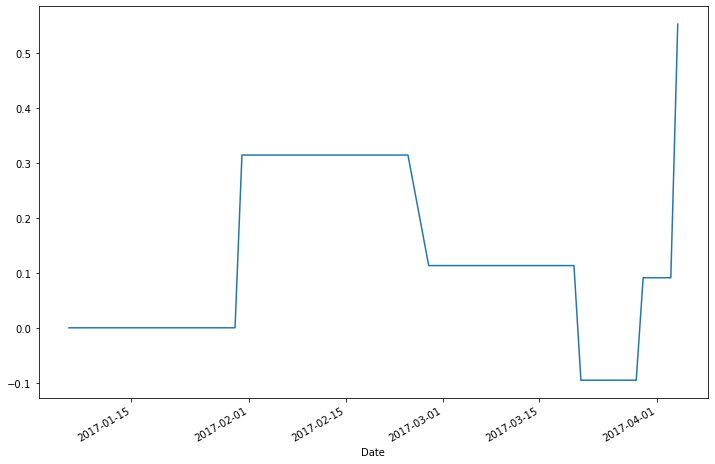

In [43]:
trades_test['Cumulative PnL'].plot(figsize=(12,8))

In [44]:
# Sharpe Ratio
sharpe_ratio = np.sqrt(252) * trades_test['Returns'].mean() / trades_test['Returns'].std()

# Maximum Drawdown
cumulative_returns = np.array(trades_test['Cumulative Returns'])
peak = np.maximum.accumulate(cumulative_returns)
drawdown = (cumulative_returns - peak) / peak
max_drawdown = np.min(drawdown)

print(f"Sharpe Ratio of the Trading Stategy: {round(sharpe_ratio,2)}")
print(f"Maximum Drawdown of the Trading Stategy: {round(max_drawdown,2)}")

Sharpe Ratio of the Trading Stategy: -2.24
Maximum Drawdown of the Trading Stategy: -0.38


In [42]:
print("Done!")

Done!
